In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('dataset', train = True, download = True, transform=transforms.Compose([transforms.ToTensor()])), batch_size = 1)

image, label = next(iter(train_loader))

In [3]:
image.shape # batch사이즈, 채널, 행, 열 순으로 들어옴

torch.Size([1, 1, 28, 28])

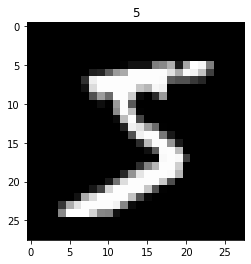

In [4]:
label = label.numpy()

plt.title(label[0])
plt.imshow(image[0, 0], 'gray')
plt.show()

# Network 쌓기 위한 준비

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# Convolution
- in_channels: 받게 될 ch.의 수
- out_channels: 보내고 싶은 ch.의 수
- kernel_size: 만들고싶은 kernel(weights)의 사이즈

In [6]:
# Tensorflow에서는 out_channel만 써주면 됐는데, pytorch에서는 in_channel도 써줘야함
nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride = 1)

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [7]:
layer = nn.Conv2d(1, 20, 5, 1).to('cuda')
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [8]:
# Weight(커널)을 확인

weight = layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

In [9]:
# detach를 써줘야만 numpy화가 됨 
# 지금은 학습이 가능한 상태여서 수정불가
weight = weight.cpu().detach().numpy()

In [10]:
output = layer(image.to('cuda'))
image_np = image.numpy()
output = output.cpu().detach().numpy()

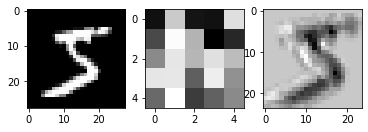

In [11]:
plt.subplot(131)
plt.imshow(image_np[0, 0], 'gray')

plt.subplot(132)
plt.imshow(weight[1, 0, :, :], 'gray')


plt.subplot(133)
plt.imshow(output[0, 0], 'gray')

plt.show()

# Pooling
input을 먼저 앞에 넣고, 뒤에 kernel 사이즈와 stride를 순서대로 넣음

In [13]:
# torch.nn은 weight가 있는애들
# torch.nn.functional은 weight가 없는애들, activation

pool = F.max_pool2d(image, 2, 2)
pool.shape

torch.Size([1, 1, 14, 14])

In [16]:
# MaxPool 층은 Weight가 없기때문에 바로 numpy() 가능 
pool_np= pool.numpy()

(1, 1, 28, 28)

(28, 28)


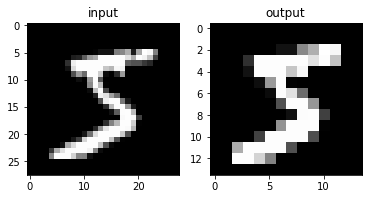

In [17]:
plt.subplot(121)
plt.title("input")
print(np.squeeze(image_np).shape)
plt.imshow(np.squeeze(image_np), 'gray')

plt.subplot(122)
plt.title("output")
plt.imshow(np.squeeze(pool_np), 'gray')

In [20]:
# Flatten 사용할거임

flatten = image.reshape(1, 28*28)
flatten.shape

torch.Size([1, 784])

In [22]:
# linear 층 만들기
lin = nn.Linear(784, 10)(flatten)
lin.shape

torch.Size([1, 10])

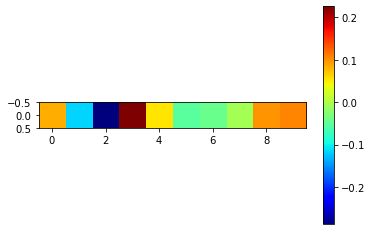

In [28]:
# lin에는 지금 weight가 있기 때문에 detach가 필요함
plt.imshow(lin.detach().numpy(), 'jet')
plt.colorbar()
plt.show()

# Softmax

In [30]:
# 매번 detach 쓰기 힘드니깐, weight를 무시하기위해(학습모드 탈출을 위해), no_grad 이용
with torch.no_grad():
    flatten = image.reshape(1, 28*28)
    lin = nn.Linear(784, 10)(flatten)
    softmax = F.softmax(lin, dim=1)

np.sum(softmax.numpy()) # 거의 1이 나온것을 확인할수있음

1.0000001

# Layer 통째로 만들기

In [40]:
class Net(nn.Module):
    def __init__(self): # 생성자
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) #입력 채널, 아웃채널, 커널사이즈, stride
        self.conv2 = nn.Conv2d(20, 50, 5, 1)

        self.fc1 = nn.Linear(4*4*50, 500) # Pool을 지나오면 (채널, 행, 렬) = (50, 4, 4) 가 됨
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        # Feature Extraction
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Fully Conneted (Classficiation)
        x = x.reshape(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [41]:
model = Net() # 모델 인스턴스화
model.forward(image) # 예측 (이미지 넣고 layer 돌리기)

tensor([[-2.2548, -2.3379, -2.2354, -2.2996, -2.2843, -2.3175, -2.3133, -2.3103,
         -2.3199, -2.3589]], grad_fn=<LogSoftmaxBackward>)

In [42]:
model.conv

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))